In [10]:
# -*- coding: utf-8 -*-


'''==========Solving job shop scheduling problem by gentic algorithm in python======='''
# importing required modules
import pandas as pd
import numpy as np
import time
import copy
from numba import cuda
''' ================= initialization setting ======================'''

pt_tmp=pd.read_excel("JSP_dataset.xlsx",sheet_name="Processing Time",index_col =[0])
ms_tmp=pd.read_excel("JSP_dataset.xlsx",sheet_name="Machines Sequence",index_col =[0])

num_job, num_mc=pt_tmp.shape 
num_gene=num_mc*num_job 

pt=[list(map(int, pt_tmp.iloc[i])) for i in range(num_job)]
ms=[list(map(int,ms_tmp.iloc[i])) for i in range(num_job)]

pt = np.array(pt)
ms = np.array(ms)


population_size=int(input('Please input the size of population: ') or 30) 
crossover_rate=float(input('Please input the size of Crossover Rate: ') or 0.8) 
mutation_rate=float(input('Please input the size of Mutation Rate: ') or 0.2) 
mutation_selection_rate=float(input('Please input the mutation selection rate: ') or 0.2)
num_mutation_jobs=round(num_gene*mutation_selection_rate) 
num_iteration=int(input('Please input number of iteration: ') or 2000) 

  
start_time = time.time()

# initial setting
def init_setting(population_size, num_gene, num_job, population_list):
    for i in range(population_size):
        nxm_random_num=list(np.random.permutation(num_gene)) 
        population_list.append(nxm_random_num) 
        for j in range(num_gene):
            population_list[i][j]=population_list[i][j]%num_job 
    return population_list

def crossover(population_list):
    parent_list=copy.deepcopy(population_list) #父母代基因
    offspring_list=copy.deepcopy(population_list) #子代基因 
    S=list(np.random.permutation(population_size)) # 30 generate a random sequence to select the parent chromosome to crossover
    
    #雙點交配法
    for m in range(int(population_size/2)): #population size 除 2 是因為在這個迴圈中會挑選兩個父母代進行交配 因此進行population size /2 次 
        crossover_prob=np.random.rand() #隨機生成交配率 因為自然界並非每個基因都有機會進行交配 因此需要設定交配率 當超過交配率時進行交配
        if crossover_rate >= crossover_prob: #根據交配率來決定是否要進行交配(8成)
            parent_1= population_list[S[2*m]][:] #挑選第一個要進行交配的父母代
            parent_2= population_list[S[2*m+1]][:] #挑選第二個要進行交配的父母代 
            child_1=parent_1[:] # 為了後續交配準備
            child_2=parent_2[:] # 為了後續交配準備
            cutpoint=list(np.random.choice(num_gene, 2, replace=False)) #隨機挑選兩個基因交配點
            cutpoint.sort() #將基因交配點由小到大排序 為了後續可以使用
            # 開始進行雙點交配
            #取代原本的母代染色體
            #由兩個基因交配點中所有基因進行交換
            child_1[cutpoint[0]:cutpoint[1]]=parent_2[cutpoint[0]:cutpoint[1]]
            child_2[cutpoint[0]:cutpoint[1]]=parent_1[cutpoint[0]:cutpoint[1]]
            offspring_list[S[2*m]]=child_1[:]
            offspring_list[S[2*m+1]]=child_2[:]
            return offspring_list, parent_list
            #雙點交配結束 產生兩個新的子代

def repairment(offspring_list):
    for m in range(population_size): #對每個新子代染色體的基因進行確認是否有重複(有可能交換完還是一樣)或缺少某些基因(可能交換完 染色體缺少某個基因) 因此需要做修整
        job_count={}
        larger,less=[],[] # 'larger' record jobs appear in the chromosome more than m times, and 'less' records less than m times.
        for i in range(num_job):
            #判斷該基因是否有在該染色體內
            if i in offspring_list[m]:
                count=offspring_list[m].count(i) #計算該基因出現在染色體內的次數
                pos=offspring_list[m].index(i) #找出該基因最先出現在染色體的哪個位置
                #job_count內存[該基因重複數,該基因第一個出現的位置] , 第幾個串列就代表第幾號基因
                job_count[i]=[count,pos] # store the above two values to the job_count dictionary
            #該基因並無出現在這個染色體內
            else:
                count=0
                job_count[i]=[count,0]
            #如果該基因出現在染色體次數大於機器數就記錄在變數lager內 之後進行修正
            if count>num_mc:
                larger.append(i)
            #如果該基因出現在染色體次數小於機器數就記錄在變數less內 之後進行修正
            elif count<num_mc:
                less.append(i)
        
        #找出多的基因 並用 缺少的基因去替補
        for k in range(len(larger)):
            chg_job=larger[k]
            while job_count[chg_job][0]>num_mc: #檢測出基因超出原本預設的
                for d in range(len(less)):
                    if job_count[less[d]][0]<num_mc: #檢測出基因少於原本預設的 
                        #找到超出預計的的基因 並用 缺少的基因去替補 ＝> offspring_list[m][找到該超出預計的基因的位置(job_count[i]=[count,pos(表示第一個出現的位置)])]=less[d] 用卻少的替補
                        offspring_list[m][job_count[chg_job][1]]=less[d]
                        #因為原先超出預計的基因的位置已經用缺少的替補了 所以要找到他的下一個基因位置 .index 找到超出預計數量基因的位置
                        job_count[chg_job][1]=offspring_list[m].index(chg_job)
                        #將超過預計數量的基因 job_count的計數減一 因為已經用缺少的取代了
                        job_count[chg_job][0]=job_count[chg_job][0]-1
                        #將少於預計數量的基因 job_count的計數加一 因為已經替補上去了
                        job_count[less[d]][0]=job_count[less[d]][0]+1    
                    #如果數量符合預計數量就不需要進行修正替補                
                    if job_count[chg_job][0]==num_mc:
                        break
    return offspring_list

def mutation(offspring_list):
    for m in range(len(offspring_list)):
        mutation_prob=np.random.rand() #隨機生成突變率
        if mutation_rate >= mutation_prob: #當設定的突變率>=隨機生成的突變率將進行突變
            m_chg=list(np.random.choice(num_gene, num_mutation_jobs, replace=False)) #隨機選擇突變的位置
            t_value_last=offspring_list[m][m_chg[0]] #保存第一個突變位置上的值
            for i in range(num_mutation_jobs-1): #基因此時會有重複 須將另一個重複基因改為缺少的值 (因為兩兩交換 因此只需進行 num_mutation_jobs-1 次)
                offspring_list[m][m_chg[i]]=offspring_list[m][m_chg[i+1]] #兩者交換移動位置
            
            offspring_list[m][m_chg[num_mutation_jobs-1]]=t_value_last #將第一個突變位置的值移動到最後一個突變位置
    return offspring_list


def fitness_value(parent_list,offspring_list):
  global total_chromosome, key_count
  total_chromosome=copy.deepcopy(parent_list)+copy.deepcopy(offspring_list) #全部的染色體=父母和子代結合
  # 必須以倒數的方式記錄 (chrom_fitness)，這樣後面採用輪盤法時，才可以選到完工時間越小的染色體，不過這邊還是有另外紀錄每個染色體原本的完工時間 (chrom_fit)
  # Fitness 越小代表此基因具有較好的資質
  chrom_fitness,chrom_fit=[],[] #存放適應值, 存放原始時間 1/time fitness (max) time (min)
  total_fitness=0 #對整個群體進行評分
  # population_size*2 是因為 total_chromosome 內數量是 parent_list + offspring_list
  for m in range(population_size*2):
    key_count={key:0 for key in range(num_job)} #為了避免從複選到 pt 和 ms 內的資料 （可以看出目前工件到第幾個步驟）由步驟可以回推到該工件在底幾步驟和在哪個機台加工
    j_count={key:0 for key in range(num_job)} #為了統計各個工件的加工時間 
    m_count={key+1:0 for key in range(num_mc)} # 統計各個機器被使用時間
    
    #進行單條基因計算（編碼）
    # pop_size * chrom_size
    for i in total_chromosome[m]: #每條基因內的基因下去計算
      gen_t=int(pt[i][key_count[i]]) # job(i) 在 第幾（key_count[i]）個步驟 所花費的時間 根據我們原本輸入的資料(processing time)
      gen_m=int(ms[i][key_count[i]]) # job(i) 在 第幾（key_count[i]）個步驟 在哪個機器上運行 根據我們原本輸入的資料(machines sequence)
      j_count[i]=j_count[i]+gen_t #累計job(i)工件加工時
      m_count[gen_m]=m_count[gen_m]+gen_t #計算機台被使用的時間
      
      #為了解決時間空擋問題(以時間大的為主)
      # 機器累計時間 小於 工件預計加工時間 代表 工件還在其他機器上加工 因此 此機台就要等待該工件完成後才能繼續接著用 所以 要以 工件累計加工時間為主
      if m_count[gen_m]<j_count[i]:
          m_count[gen_m]=j_count[i]
      # 機器累計時間 大於 工件預計加工時間 代表 這個工件要等待機器完成 會有空窗時間 當機器做完上一個工作時就可以馬上接上繼續加工 因此時間要以機台為主
      elif m_count[gen_m]>j_count[i]:
          j_count[i]=m_count[gen_m]
      ##為了解決時間空擋問題
      
      key_count[i]=key_count[i]+1 #（紀錄工作加工到第幾個步驟）可避免下一次取到一樣的

    makespan=max(j_count.values()) #取工件中時間最長的 因為要等全部做完才算完成所有工作因此就選時間最長的 當作整個製作流程的時間
    chrom_fitness.append(1/makespan) #倒數 是為了讓時間越長的分數越小 因為我們越不想使用它 因此給它評分越低
    chrom_fit.append(makespan) #放入原始時間
    total_fitness=total_fitness+chrom_fitness[m] #計算整個群體的fitness value 對整個群體進行評分
  return chrom_fitness, total_fitness, total_chromosome, chrom_fit

# Use the parallel method to calculate the fitness value
@cuda.jit
def fitness_value_parallel(total_chromosome,j_count,m_count,key_count):
  # thread(執行緒)索引，block(區塊)中thread(執行緒)的索引
  tx = cuda.threadIdx.x
  # Block(區塊)索引，grid(網格)中block(區塊)的索引
  ty = cuda.blockIdx.x
  # block(區塊)大小，block(區塊)中包含的thread(執行緒)數目
  bw = cuda.blockDim.x
  # 算出thread在整個grid中的位置编號(可以看要計算的是第幾個染色體)
  pos = tx + ty * bw 
  if pos < population_size*2:
    for i in total_chromosome[pos]:
      gen_t=pt[i,key_count[i+10*pos]]
      gen_m=ms[i,key_count[i+10*pos]]
      j_count[i+10*pos]+=gen_t 
      m_count[gen_m+10*pos]+=gen_t
      key_count[i+10*pos]+=1
      if m_count[gen_m+10*pos]<j_count[i+10*pos]:
          m_count[gen_m+10*pos]=j_count[i+10*pos]
      # 機器累計時間 大於 工件預計加工時間 代表 這個工件要等待機器完成 會有空窗時間 當機器做完上一個工作時就可以馬上接上繼續加工 因此時間要以機台為主
      elif m_count[gen_m+10*pos]>j_count[i+10*pos]:
          j_count[i+10*pos]=m_count[gen_m+10*pos]

def selection(chrom_fitness, total_fitness, population_list, total_chromosome):
    pk,qk=[],[] #存放選擇幾率pk及累積機率qk值
    
    for i in range(population_size*2): #計算所有要被選擇染色體的適應值總和
        pk.append(chrom_fitness[i]/total_fitness) #對每個染色體計算其選擇機率pk 計算分數佔比
    for i in range(population_size*2): #計算所有要被選擇染色體的適應值總和
        cumulative=0 #對每個染色體計算其累積機率qk
        for j in range(0,i+1):
            cumulative=cumulative+pk[j]
        qk.append(cumulative)
    
    selection_rand=[np.random.rand() for i in range(population_size)] #從[0,1]區間隨機產生一個數字 
    
    for i in range(population_size):
        #若隨機產生的數字<=qK1，則選擇第一條染色體
        if selection_rand[i]<=qk[0]:
            population_list[i]=copy.deepcopy(total_chromosome[0])
        #否則當qk-1<隨機產生的數字<qk，則選擇第i個染色體
        else:
            for j in range(0,population_size*2-1):
                if selection_rand[i]>qk[j] and selection_rand[i]<=qk[j+1]:
                    population_list[i]=copy.deepcopy(total_chromosome[j+1])
                    break #直到選擇的染色體數量達到所設定族群大小，則停止
    return population_list

def comparison(total_chromosome,chrom_fit,Tbest_now, Tbest):
    global sequence_best,makespan_record
    for i in range(population_size*2):
        #如果chrom_fit內的時間小於我們預設的最佳時間 就以Tbest_now儲存
        if chrom_fit[i]<Tbest_now: 
            Tbest_now=chrom_fit[i] #Ｔbest_now儲存目前最佳時間
            sequence_now=copy.deepcopy(total_chromosome[i]) #存目前最佳的排程

    if Tbest_now<=Tbest: #若此解比最佳解還好
        Tbest=Tbest_now #就會替代Tbest
        sequence_best=copy.deepcopy(sequence_now) #存目前最佳的排程
        
    makespan_record.append(Tbest) #記錄該解所得到的排程結果
    return sequence_best, Tbest

# We designed a score function to address the limitations of the parallel function in processing complex calculations and supporting certain methods
def score(j_count):
    fitness = []
    fit = []
    for i in range(int(len(j_count)/10)):
        temp_max = max(j_count[i:i+10])
        fitness.append(1/temp_max)
        fit.append(temp_max)
    return fitness, fit

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numba\cuda\compiler.py:726: NumbaPerformanceWarning: Grid size (2) < 2 * SM count (6) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numba\cuda\cudadrv\devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\numba\cuda\compiler.py:726: NumbaPerformanceWarning: Grid size (2) < 2 * SM count (6) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


optimal sequence [4, 3, 5, 3, 2, 8, 2, 3, 1, 4, 4, 0, 5, 5, 6, 1, 2, 9, 1, 0, 0, 8, 3, 1, 1, 5, 8, 5, 0, 2, 1, 5, 3, 1, 0, 7, 4, 8, 1, 2, 0, 6, 7, 4, 9, 7, 4, 5, 1, 2, 8, 9, 3, 0, 3, 4, 4, 2, 9, 3, 9, 8, 8, 2, 6, 7, 7, 9, 9, 2, 1, 5, 8, 7, 8, 6, 6, 7, 9, 7, 9, 6, 7, 0, 6, 4, 2, 6, 7, 3, 9, 5, 5, 4, 6, 6, 3, 0, 0, 8]
optimal value:1296.000000
the elapsed time:40.54719638824463


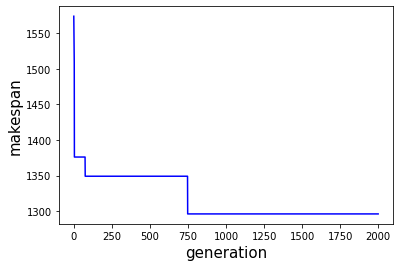

In [11]:
'''==================== main code gpu-parallel==============================='''
'''----- generate initial population -----'''
import numpy as np
Tbest=999999999999999 #設定停止條件
best_list,best_obj=[],[] #存放最佳解 (下此補充)
population_list=[] #存放產生的所有解
makespan_record=[] 
# 產生初代
population_list = init_setting(population_size, num_gene, num_job, population_list)
# 產生初代
# 開始進行演化 自訂要跑幾代

start_time = time.time()

for n in range(num_iteration):
    # chrom_fitness,chrom_fit=[],[] #存放適應值, 存放原始時間 1/time fitness (max) time (min)
    total_fitness=0
    Tbest_now=99999999999         #設定預計預計停止的分數  
    blocks_per_grid, threads_per_block = 2,32
    '''-------- two point crossover --------'''
    offspring_list, parent_list = crossover(population_list)        
    '''----------repairment-------------'''
    #將重複或缺少的進行修復
    offspring_list = repairment(offspring_list)     
    '''--------mutatuon--------'''   
    #將所有新的子代進行突變(進行基因組內交換)
    offspring_list = mutation(offspring_list)
    '''--------fitness value(calculate makespan)-------------''' #（有按照既定順序進行計算）
     #對整個群體進行評分
    total_chromosome=copy.deepcopy(parent_list)+copy.deepcopy(offspring_list)
    a_parent_ls = np.array(parent_list)
    a_offspring_ls = np.array(offspring_list)
    t_c_ls = np.concatenate([a_parent_ls,a_offspring_ls])
    key_count = np.zeros(600,dtype=np.intc) #為了避免從複選到 pt 和 ms 內的資料 （可以看出目前工件到第幾個步驟）由步驟可以回推到該工件在底幾步驟和在哪個機台加工
    j_count= np.zeros(600,dtype=np.intc) #為了統計各個工件的加工時間 
    m_count = np.zeros(600,dtype=np.intc)
    fitness_value_parallel[blocks_per_grid, threads_per_block](t_c_ls,j_count,m_count,key_count)
    chrom_fitness,chrom_fit = score(j_count)
    total_fitness = sum(chrom_fitness)
    population_list = selection(chrom_fitness, total_fitness, population_list, total_chromosome)
    sequence_best, Tbest = comparison(total_chromosome,chrom_fit,Tbest_now, Tbest)


'''----------result----------'''
print("optimal sequence",sequence_best)
print("optimal value:%f"%Tbest)
print('the elapsed time:%s'% (time.time() - start_time))

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([i for i in range(len(makespan_record))],makespan_record,'b')
plt.ylabel('makespan',fontsize=15)
plt.xlabel('generation',fontsize=15)
plt.show()


'''--------plot gantt chart-------'''
import pandas as pd
from chart_studio import plotly
# from plotly.figure_factory import create_gantt
# import plotly.plotly as py
import plotly.figure_factory as ff
import datetime

m_keys=[j+1 for j in range(num_mc)]
j_keys=[j for j in range(num_job)]
key_count={key:0 for key in j_keys}
j_count={key:0 for key in j_keys}
m_count={key:0 for key in m_keys}
j_record={}
for i in sequence_best:
    gen_t=int(pt[i][key_count[i]])
    gen_m=int(ms[i][key_count[i]])
    j_count[i]=j_count[i]+gen_t
    m_count[gen_m]=m_count[gen_m]+gen_t
    
    if m_count[gen_m]<j_count[i]:
        m_count[gen_m]=j_count[i]
    elif m_count[gen_m]>j_count[i]:
        j_count[i]=m_count[gen_m]
    
    start_time=str(pd.Timedelta(seconds=j_count[i]-pt[i][key_count[i]])) # convert seconds to hours, minutes and seconds
    end_time=str(pd.Timedelta(seconds=j_count[i]))
        
    j_record[(i,gen_m)]=[start_time,end_time]
    
    key_count[i]=key_count[i]+1
